# Image Operations

**Task**: perform broadcast and reduction operations on a tensor representing a batch of color images

**Goal**: The goal of this exercise was just to get used to thinking about shapes of multidimensional structures. A surprisingly large amount of the thinking that goes into implementing neural net code is getting the shapes right. I didn’t really believe that until I had to figure it out myself a couple of times, and that convinced me that everyone could use some guided practice with that.

# Setup

As usual, you don't need to understand the code in this section.

In [1]:
# Check versions of Keras and Tensorflow
!pip install -U keras einops
!pip list | egrep 'keras|tensorflow |jax '

fish: Unknown command: pip
fish: 
pip install -U keras einops
^~^
fish: Unknown command: pip
fish: 
pip list | egrep 'keras|tensorflow |jax '
^~^


In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import einops
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")

Keras version: 3.0.5, backend: jax


In [9]:
def show_image(image, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    img = np.array(image)
    context = {}
    if len(img.shape) == 2 or img.shape[2] == 1:
        # grayscale
        context = {'image.cmap': 'gray'}
    with matplotlib.rc_context(rc=context):
        ax.imshow(img.astype('uint8'))

def show_image_grid(images, titles=None, rows=None, cols=3, title_fontsize=8, figsize=(10, 10)):
    if rows is None:
        rows = (len(images) + (cols - 1)) // cols

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    # Turn off *all* axes (even those that we wouldn't show an image in)
    for ax in axs.flatten(): ax.axis('off')
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images): break
        show_image(images[i], ax=ax)
        if titles is not None:
            ax.set_title(titles[i], fontsize=title_fontsize)

def get_images_from_dataset(dataset, indices):
    if hasattr(dataset, 'file_paths'):
        # FIXME: hardcoded options
        img_loader_opts = dict(target_size=(256, 256), keep_aspect_ratio=True)
        items_by_idx = {idx: keras.utils.load_img(dataset.file_paths[idx], **img_loader_opts) for idx in indices}
    else:
        items_by_idx = {idx: item for idx, (item, label) in enumerate(dataset.unbatch()) if idx in indices}
    return [items_by_idx[idx] for idx in indices]    


### Configure

In [10]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "efficientnetv2_b0_imagenet"

# Reproducibility: Set a seed so that the results are the same every time this is run.
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
keras.utils.set_random_seed(config.seed)

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [5]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)

Let's see what just got downloaded.

In [11]:
data_path = Path(path_to_downloaded_file).parent / 'flower_photos'
!ls {data_path}

/usr/local/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


LICENSE.txt  daisy/       dandelion/   roses/       sunflowers/  tulips/


We'll use a Keras helper function to load the data.

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [35]:
# Define which classes we want to use, in what order.
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


Let's show some example images.

2024-02-29 11:26:05.039732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


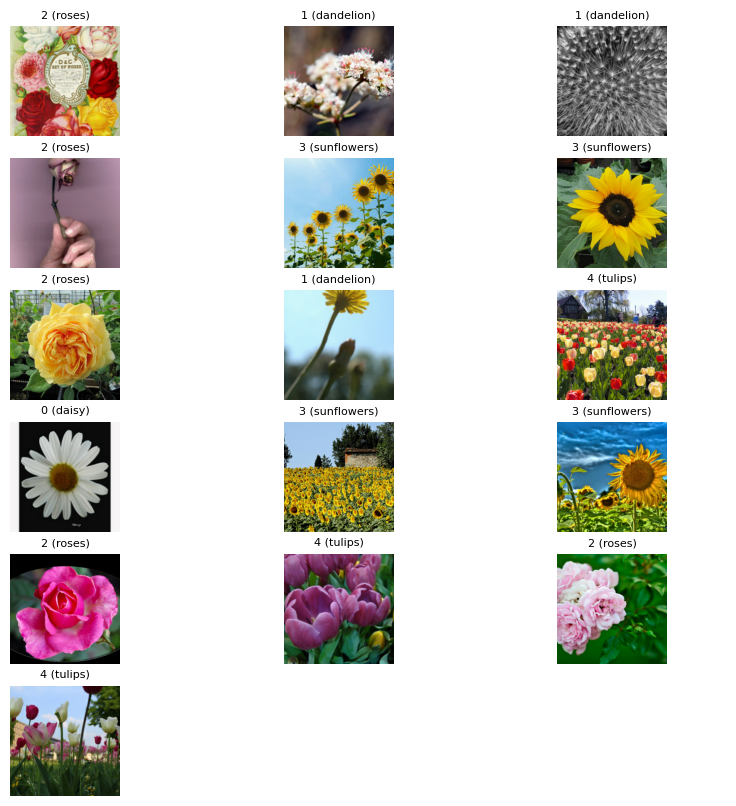

In [36]:
[[images, labels]] = train_dataset.take(1)
images = images.numpy()
labels = labels.numpy()
show_image_grid(
    images,
    titles=[f"{label} ({class_names[label]})" for label in labels])

##  Load the backbone

In [37]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

In [38]:
first_conv = model.backbone.layers[2]
w, = first_conv.get_weights()
w.shape

(3, 3, 3, 32)

In [39]:
first_conv.strides

(2, 2)

In [40]:
1/model.backbone.layers[1].scale

255.0

In [41]:
images.shape

(16, 256, 256, 3)

In [42]:
first_conv_out = first_conv(images)
first_conv_out.shape

(16, 128, 128, 32)

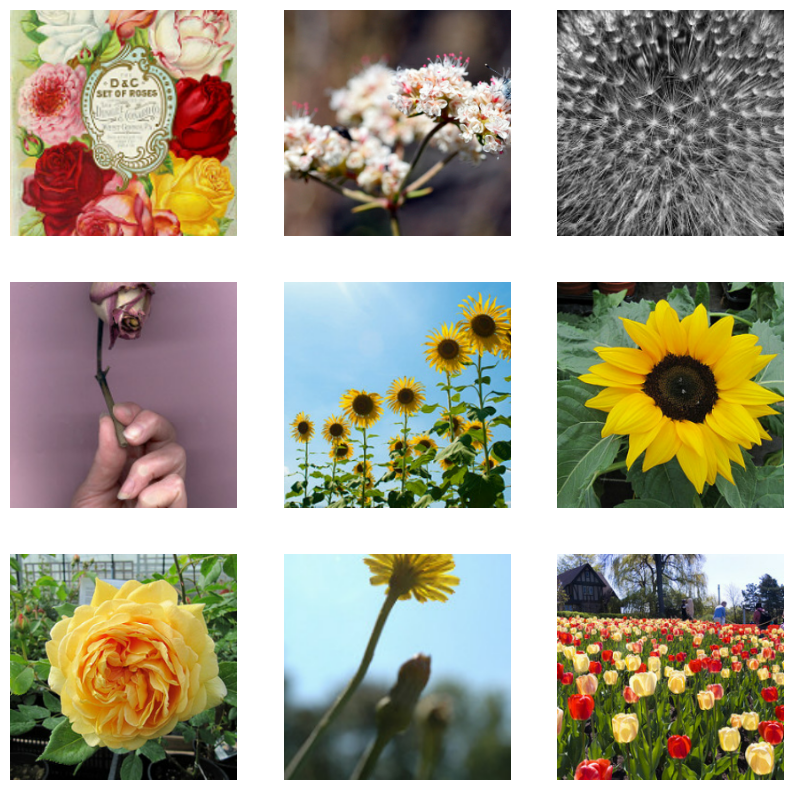

In [43]:
show_image_grid(images[:9])

# Task

Note: *all of these operations are one-liners*. If you find yourself writing lots of code, pause and think more (or ask for help).

1. **Evaluate `images.shape`**. What does each number represent?

In [44]:
images.shape

(16, 256, 256, 3)

*your answer here*

2. **Evaluate `labels`**. Explain those numbers, with the help of `class_names`.

In [46]:
labels

array([2, 1, 1, 2, 3, 3, 2, 1, 4, 0, 3, 3, 2, 4, 2, 4], dtype=int32)

In [47]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

3. **Show the first image in the batch.** (Use `show_image`.)

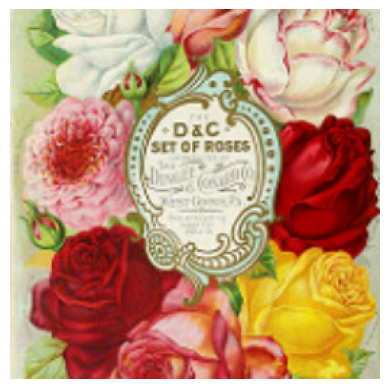

In [48]:
# your code here

4. **Show the average image.** Hint: you can compute this by taking the `.mean(axis=___)`; think about what the blank is.

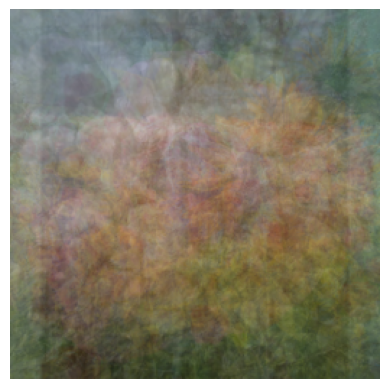

In [49]:
# your code here

5. Show the average of the **middle 3 images.**

You'll need to use *slicing* to compute this. To make sure you're doing it right, first *show the middle 3 images*.

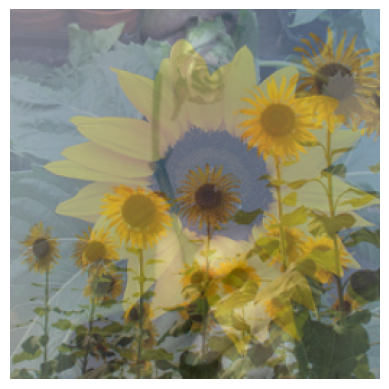

In [50]:
# your code here

6. **Show the grayscale version of all of the images.**

- *Do this by making minimal changes to the previous exercise; do not import anything new.*
- For simplicity, just use an equal weighting of the red, green, and blue channels, i.e., take the `mean` across channels.
- You can use `show_image_grid` to show all of the images.

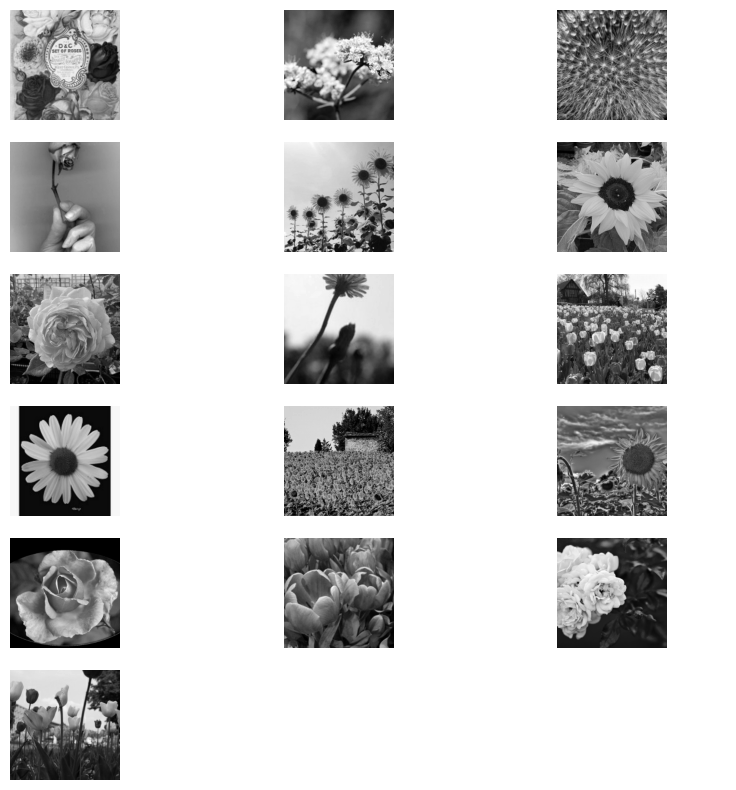

In [55]:
# your code here

7. **Invert the color of the grayscale images** (e.g., black becomes white). Show the result.

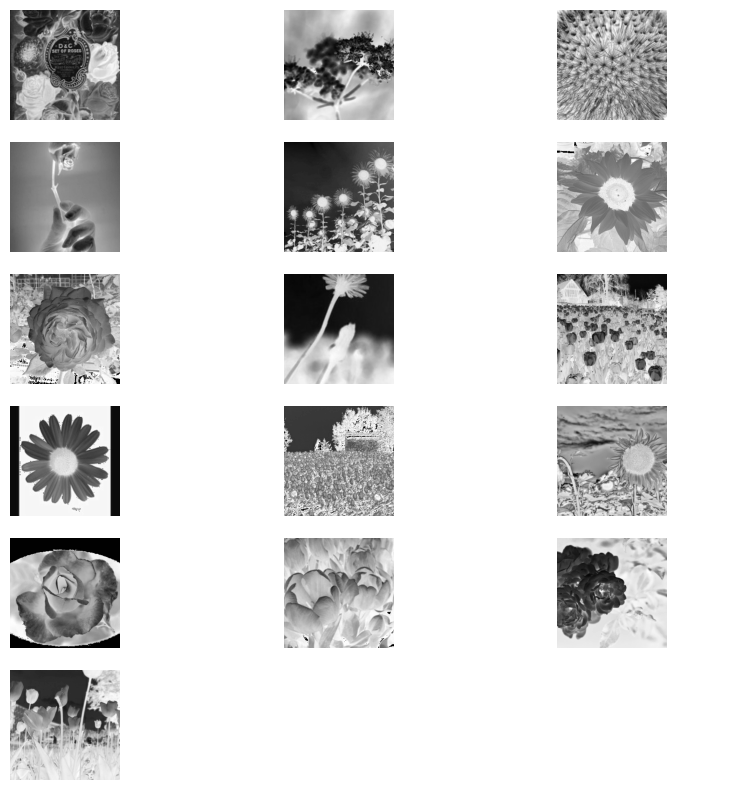

In [56]:
# your code here

## Second Set of Tasks

These are a bit more involved; you might need two or three lines of code.

The next exercise will require you to **assign to slices**. It wil also require you to "skip" dimensions in slicing. To prepare, study what this does:

In [57]:
images.shape

(16, 256, 256, 3)

Consider assigning to a slice along the first dimension. First, we'll assign to a single index on that dimension. Think about what shape we get from a single item on the first dimension:

In [58]:
images[0].shape

(256, 256, 3)

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

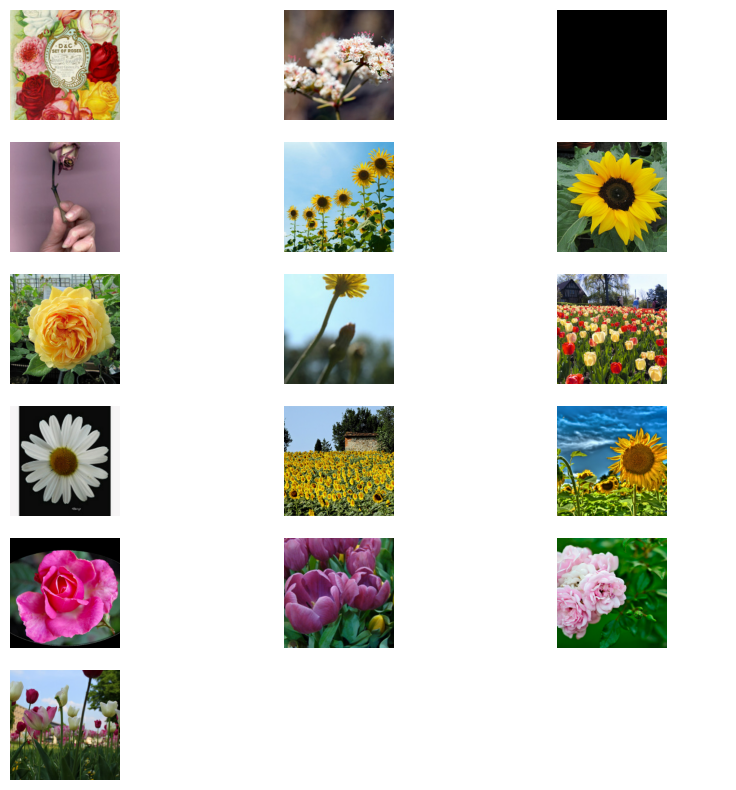

In [61]:
# The following three lines are equivalent in this case:
images_orig = images.copy()
images[2] = 0.0
images[2] = np.zeros((256, 256, 3))
images[2, :, :, :] = 0.0
show_image_grid(images)
images = images_orig.copy() # restore the original images

Now the same thing, but with a slice:

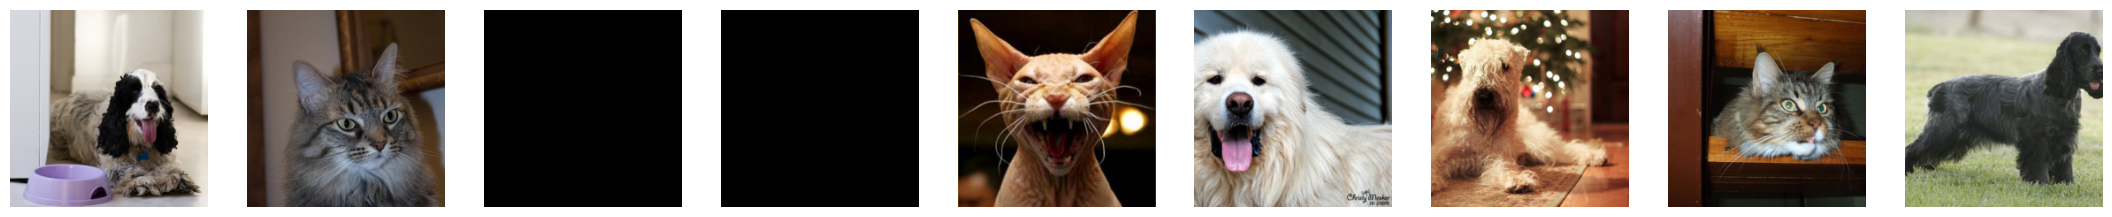

In [21]:
# assign to first dimension. The following three lines are equivalent in this case:
images[2:4] = 0.0
images[2:4] = torch.zeros(2, 3, 224, 224)
images[2:4, :, :, :] = 0.0
show_images(images)
images = images_orig.clone() # restore the original images

Now we slice along the second dimension:

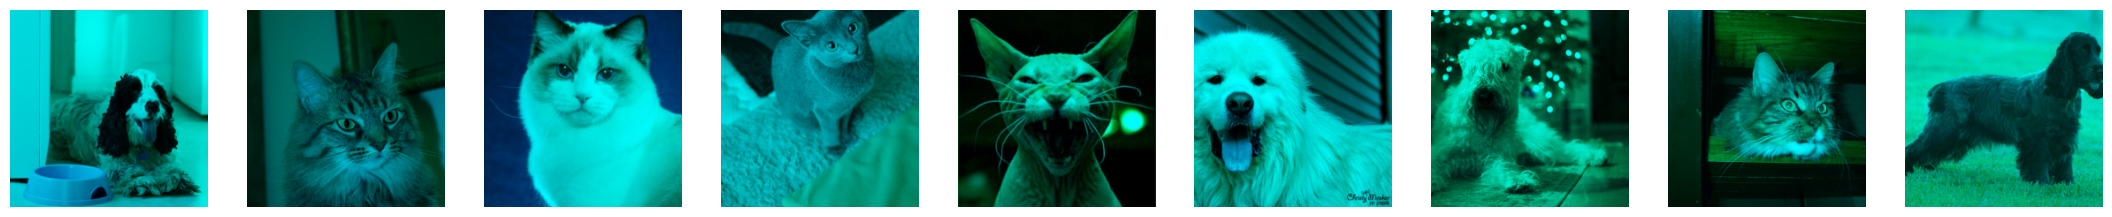

In [22]:
images[:, 0] = 0.0
show_images(images)
images = images_orig.clone() # restore the original images

Try this for the third dimension:

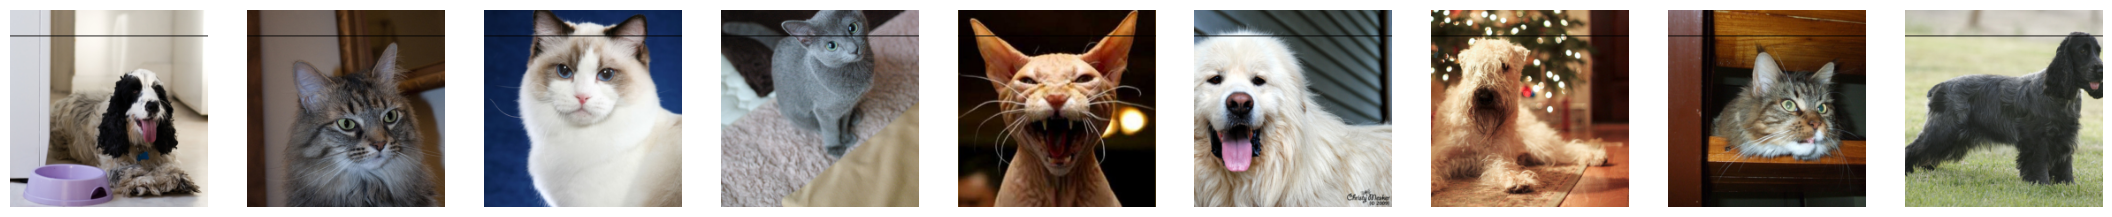

In [23]:
images[:, :, 30] = 0.0
show_images(images)
images = images_orig.clone() # restore the original images

8. **Black out (set to 0) the top 75 pixels of each image, then grey out (set to 0.5) the right 50 pixels of each image.**

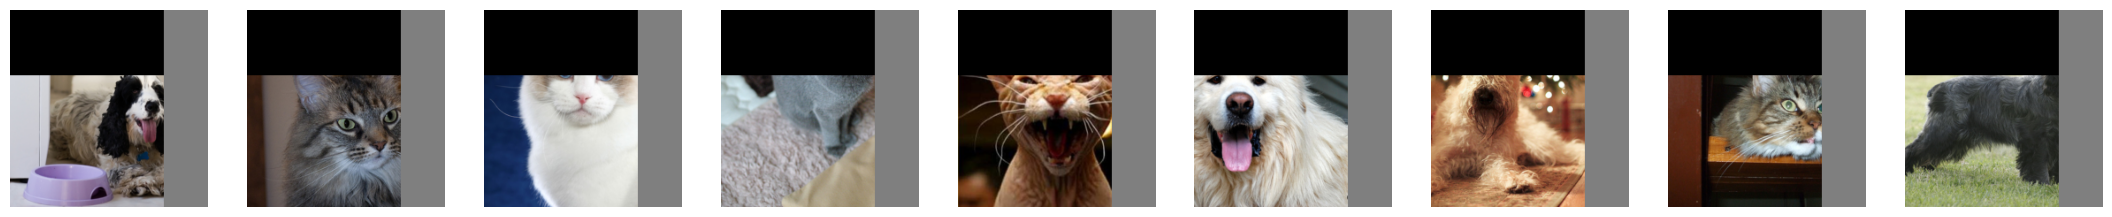

In [24]:
# your code here

In [25]:
# restore the original images for the next step
images = images_orig.clone()

9. **Show only the red color channel** by zeroing out the green and blue channels.

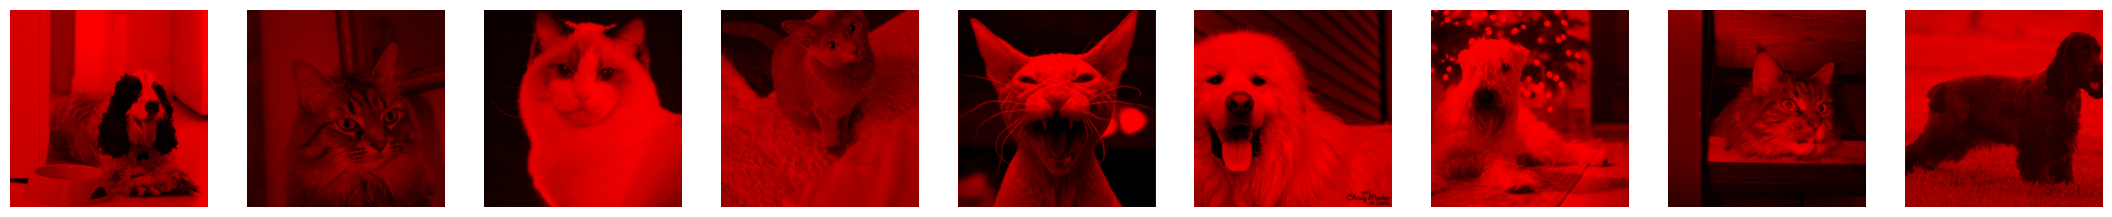

In [26]:
# your code here